In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("city_day.csv")


In [2]:

print(df.dtypes) # Check data types

# Filter for Mumbai
df = df[(df['City'] == "Mumbai")]

df = df.ffill()

# Forward fill empty rows with previous values to avoid missing values problems later
df = df.ffill()

# Drop rows where aqi values are not available, just to be sure
df = df.dropna(subset = ['AQI'])

#print(df.head())
#print(df.tail())

# Convert Date column into datetime type
df['date_modified'] = pd.to_datetime(df['Date'], dayfirst=True)

# Now drop the original Date column and rename the new column as Date, then make it the first column
df.drop(['Date'], axis=1, inplace=True)
df.rename(columns = {'date_modified':'Date'}, inplace = True)
df = df[['Date','AQI']]

df.set_index('Date',inplace=True) # inplace will make the change permanent to the DF
df.index = pd.DatetimeIndex(df.index).to_period('D')

#print(df.head())
#print(df.tail())



City           object
Date           object
PM2.5         float64
PM10          float64
NO            float64
NO2           float64
NOx           float64
NH3           float64
CO            float64
SO2           float64
O3            float64
Benzene       float64
Toluene       float64
Xylene        float64
AQI           float64
AQI_Bucket     object
dtype: object


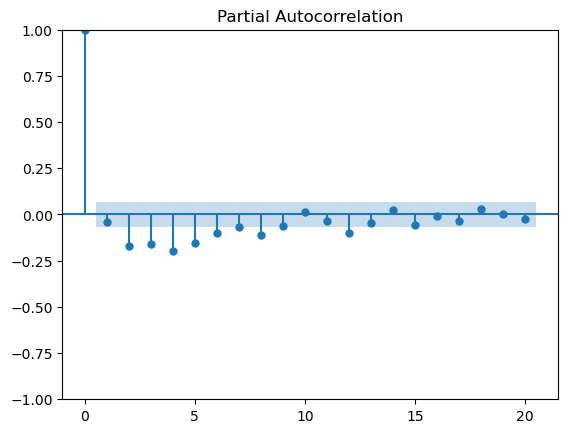

In [4]:

# Now ARIMA
# In google colab, you may need !pip install pmdarima

aqi = df[['AQI']].copy(deep=True)

# Create columns for one past row and 12 past rows 
aqi['firstDiff'] = aqi['AQI'].diff(1)
aqi['Diff3'] = aqi['AQI'].diff(12) # This will be used later in SARIMAX


from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_pacf(aqi['firstDiff'].dropna(),lags=20)
plt.show()

# Shaded area is insignificant area
# PACF gives us the auto regressive values (i.e. p - Refer to the slides)
# First 'p' is 1 (the x-axis coordinate), whose value is ~-0.50 (the y-axis coordinate)
# So, significant p values are 1, 2, 6, 7, 8, 9, etc) 


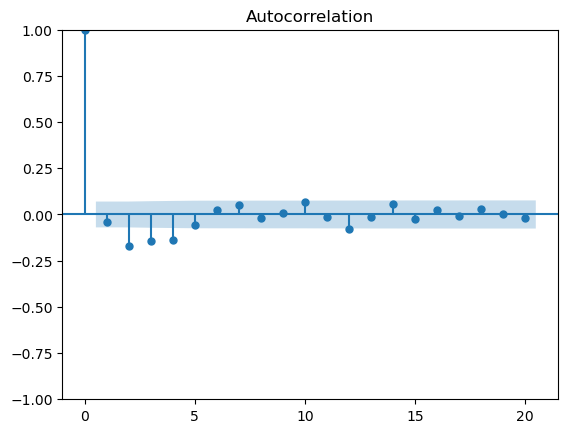

In [6]:

# Now let us take this value as p later. Now find q, for which we need ACF.
plot_acf(aqi['firstDiff'].dropna(),lags=20)
plt.show()

# Results of ACF are not similar to that of PACF
# Interpretation: We got q. The only significant q value is 1 
# Let us take p = 2, q = 1 (both are significant) and d = 1 (already known)


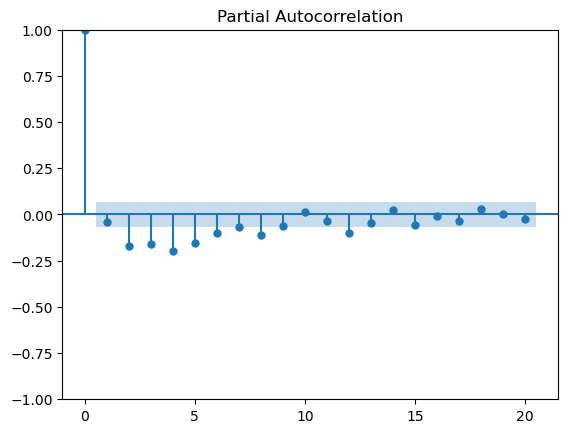

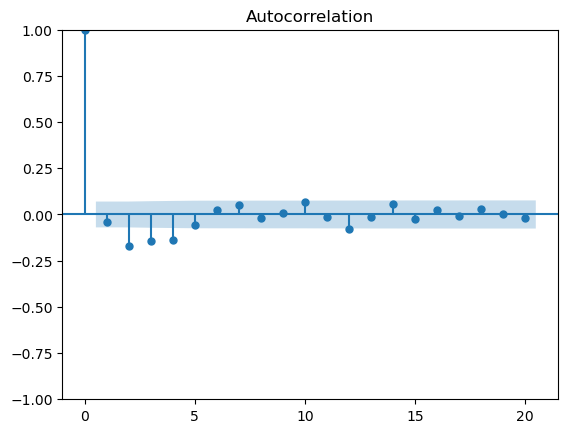

              AQI  firstDiff  Diff3
Date                               
2019-11-04   78.0        7.0    6.0
2019-11-05   79.0        1.0   -8.0
2019-11-06  105.0       26.0   23.0
2019-11-07   84.0      -21.0   15.0
2019-11-08   57.0      -27.0  -48.0
              AQI  firstDiff  Diff3
Date                               
2019-11-09   82.0       25.0  -10.0
2019-11-10   97.0       15.0  -16.0
2019-11-11  108.0       11.0   11.0
2019-11-12  134.0       26.0   53.0
2019-11-13  140.0        6.0   63.0


/home/dai/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/dai/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/dai/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


             AQI  firstDiff  Diff3  arimaPred
Date                                         
2020-06-27  64.0        7.0   15.0  78.926306
2020-06-28  64.0        0.0   10.0  78.926306
2020-06-29  54.0      -10.0    8.0  78.926306
2020-06-30  54.0        0.0    4.0  78.926306
2020-07-01  53.0       -1.0   -5.0  78.926306
              AQI  firstDiff  Diff3  arimaPred
Date                                          
2019-11-09   82.0       25.0  -10.0  65.256298
2019-11-10   97.0       15.0  -16.0  72.159780
2019-11-11  108.0       11.0   11.0  76.897550
2019-11-12  134.0       26.0   53.0  79.568913
2019-11-13  140.0        6.0   63.0  80.678832
2019-11-14  128.0      -12.0   71.0  80.810445
2019-11-15  131.0        3.0   60.0  80.454182
2019-11-16  149.0       18.0   71.0  79.948209
2019-11-17  149.0        0.0   70.0  79.484288
2019-11-18  140.0       -9.0   35.0  79.142997
2019-11-19  184.0       44.0  100.0  78.934912
2019-11-20  209.0       25.0  152.0  78.835443
2019-11-21  209.0   

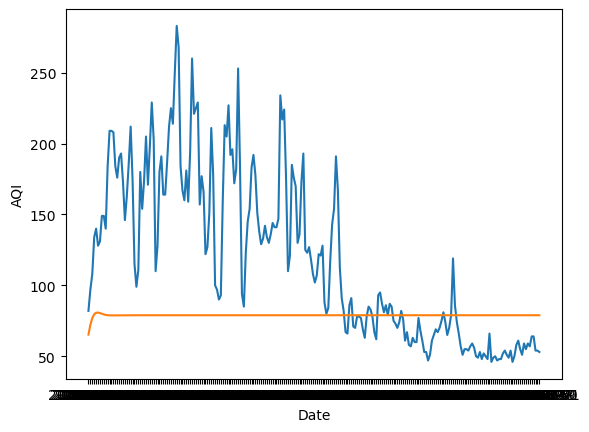

In [3]:

# Build ARIMA model
train = aqi[:round(len(aqi)*70/100)] # Take the first 70% data
print(train.tail()) # Just to check where it ends

test = aqi[round(len(aqi)*70/100):] # Take the last 30% data, starting from 71%
print(test.head()) # Just to check where it starts

model = ARIMA(train['AQI'],order=(2,1,2)) # Parameters: p, d, q
model_fit = model.fit()
# prediction = model_fit.predict(start=test.index[0],end=test.index[-1])
prediction = model_fit.predict(start=train.shape[0],end=(train.shape[0]+test.shape[0]-1), dynamic=False)
aqi['arimaPred'] = prediction
print(aqi.tail())

# While running the code, I realized that the arimaPred values were becoming nulls, so added the following code

aqi_no_nulls = aqi.dropna(subset=['arimaPred']) 

pd.set_option('display.max_rows', None)
print(aqi_no_nulls)

# Plot

#sns.lineplot(data=aqi,x=aqi.index,y='AQI')
#sns.lineplot(data=aqi,x=aqi.index,y='arimaPred')

sns.lineplot(data=aqi_no_nulls,x=aqi_no_nulls.index.astype(str),y='AQI')
sns.lineplot(data=aqi_no_nulls,x=aqi_no_nulls.index.astype(str),y='arimaPred')

plt.show()

# Conclusion: The ARIMA prediction is not good


In [ ]:

# SARIMAX

from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(train['AQI'],order=(2,1,2),seasonal_order=(2,1,2,12))
model_fit = model.fit()
prediction = model_fit.predict(start=test.index[0],end=test.index[-1])
aqi_no_nulls['sarimaxPred'] = prediction
print(aqi_no_nulls.tail())

# Plot
aqi_no_nulls.dropna()
print(aqi_no_nulls.head())
sns.lineplot(data=aqi_no_nulls,x=aqi_no_nulls.index.astype(str),y='AQI')
sns.lineplot(data=aqi_no_nulls,x=aqi_no_nulls.index.astype(str),y='sarimaxPred')
sns.lineplot(data=aqi_no_nulls,x=aqi_no_nulls.index.astype(str),y='arimaPred')
plt.show()


# Future prediction

# First check the last date in our dataset
print(aqi_no_nulls.tail())
